# QC of 3 PBMC 10x datasets

Same datasets as in QC tutorial from Seurat.

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()


scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
data_p3 = sc.read_10x_h5(
    './../data/3pbmc/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5', gex_only = True)  
# OBS! gex_only to only read gene expression data.
data_p3.var_names_make_unique()

data_v2 = sc.read_10x_h5(
    './../data/3pbmc/pbmc_1k_v2_filtered_feature_bc_matrix.h5')
data_v2.var_names_make_unique()

data_v3 = sc.read_10x_h5(
    './../data/3pbmc/pbmc_1k_v3_filtered_feature_bc_matrix.h5')
data_v3.var_names_make_unique()


reading ./../data/3pbmc/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./../data/3pbmc/pbmc_1k_v2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./../data/3pbmc/pbmc_1k_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Merge the datasets into one object.

In [5]:
# first add in batch info in metadata
data_v2.obs['lib_prep'] = 'v2'
data_v3.obs['lib_prep'] = 'v3'
data_p3.obs['lib_prep'] = 'p3'



adata = data_v2.concatenate(data_v3, data_p3)
del(data_v2)
del(data_v3)
del(data_p3)


Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [6]:
print(adata.obs['lib_prep'].value_counts())

adata

v3    1222
v2     996
p3     713
Name: lib_prep, dtype: int64


AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep'
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing

Basic filtering.

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 62 cells that haveless than 200 genes expressed
filtered out 16758 genes that are detectedin less than 3 cells


Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


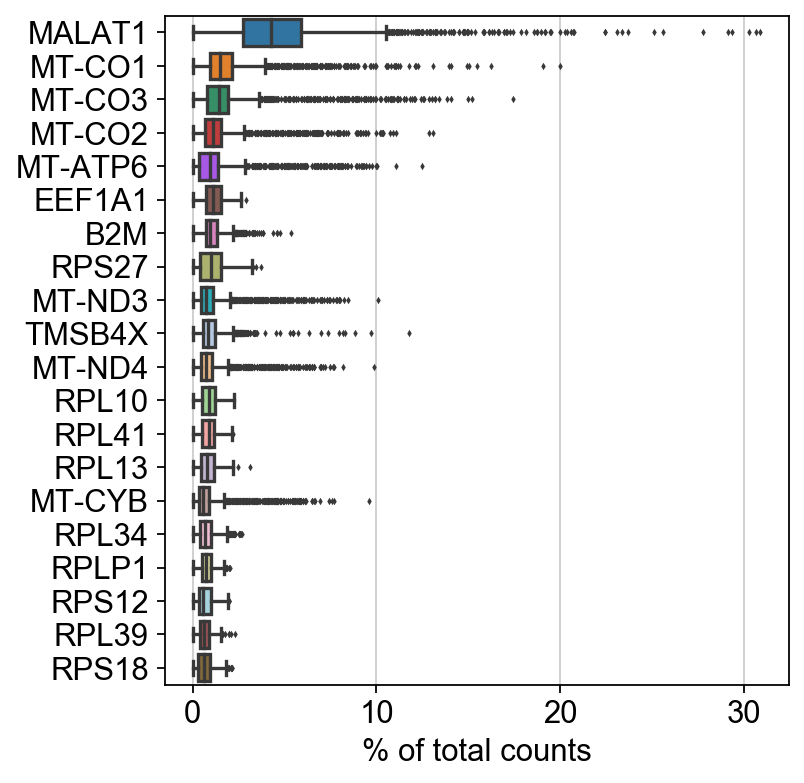

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 consitutes up to 30% of the umis from a single cell and the other top genes are mitochondrial.

Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

print(sum(mito_genes))

13


Aslo calculate proportion ribosomal proteins

In [10]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1



99


A violin plot of the computed quality measures.

... storing 'lib_prep' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


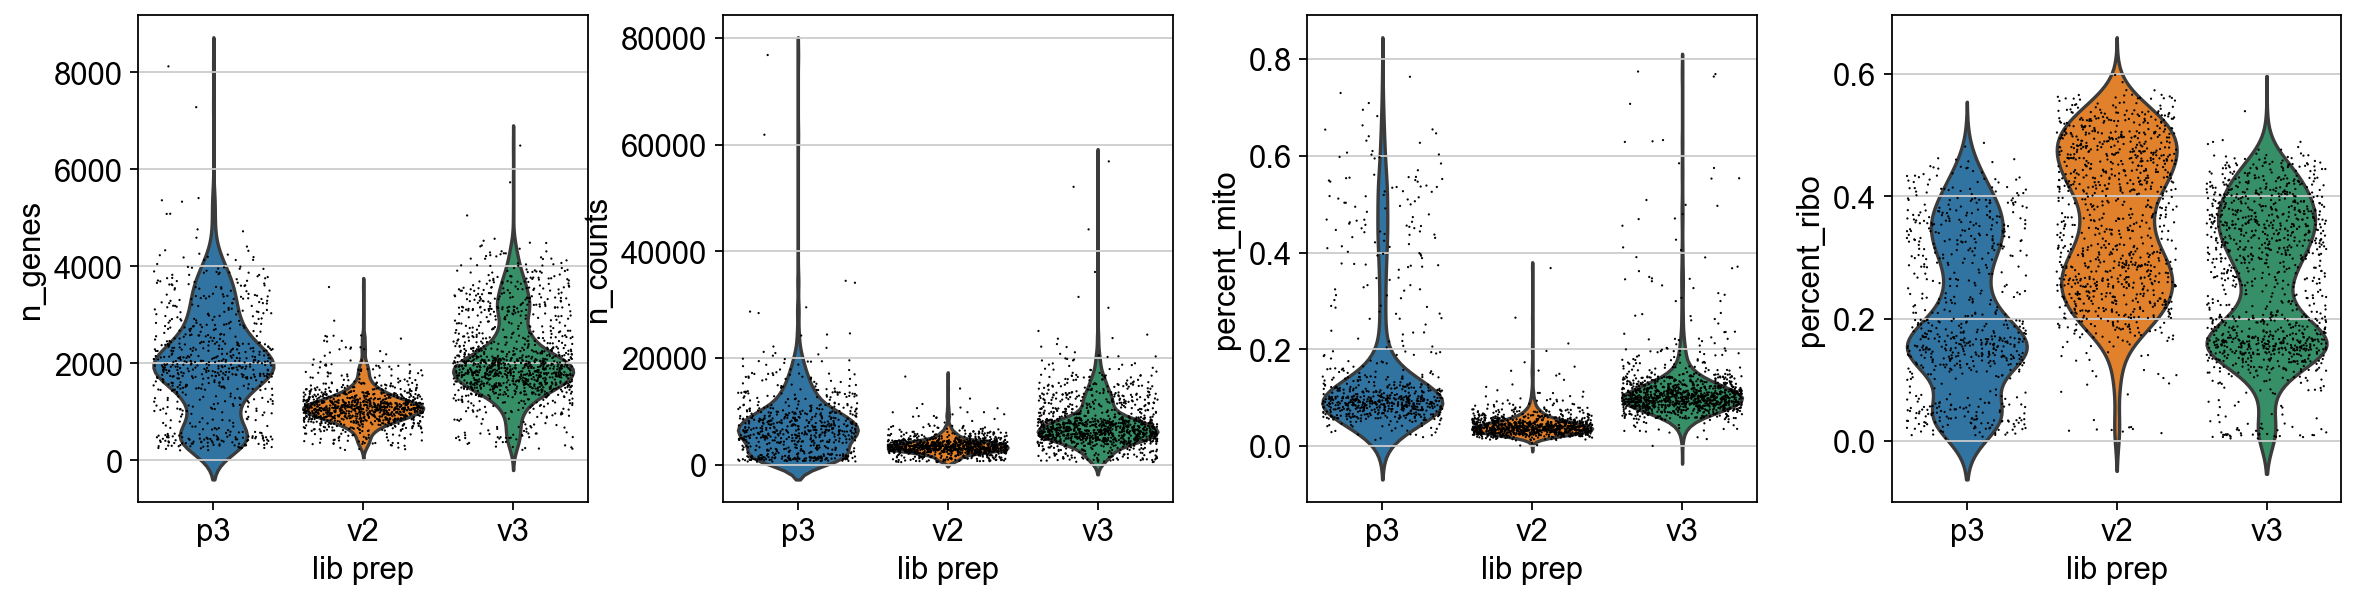

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

Remove cells that have too many mitochondrial genes expressed or too many total counts.

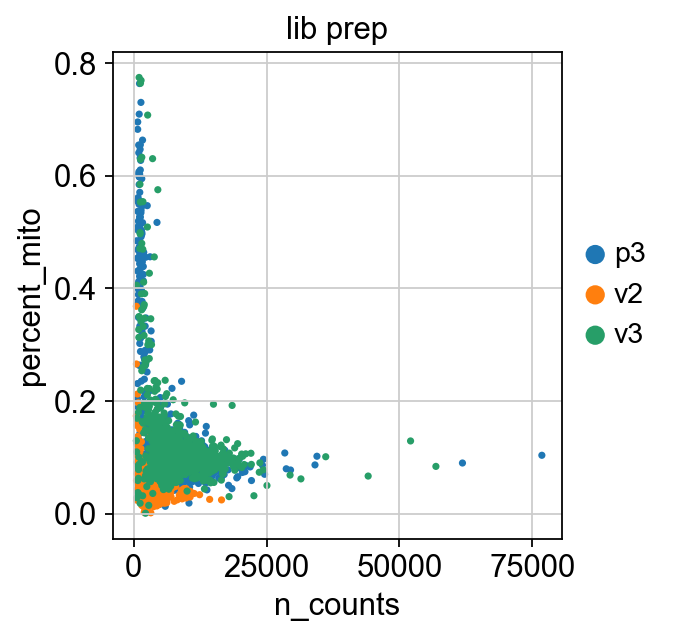

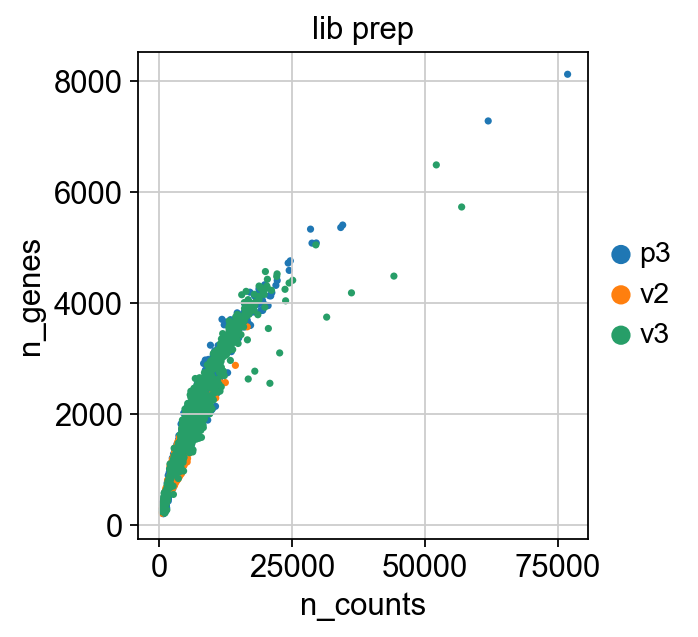

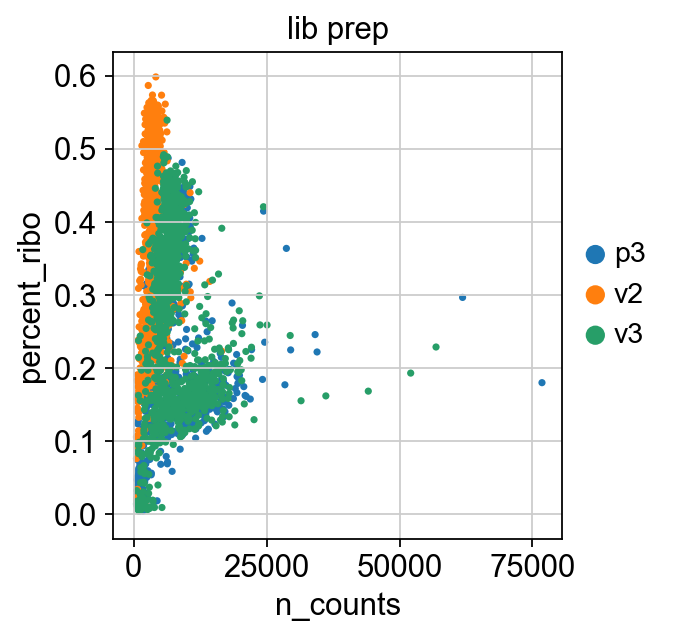

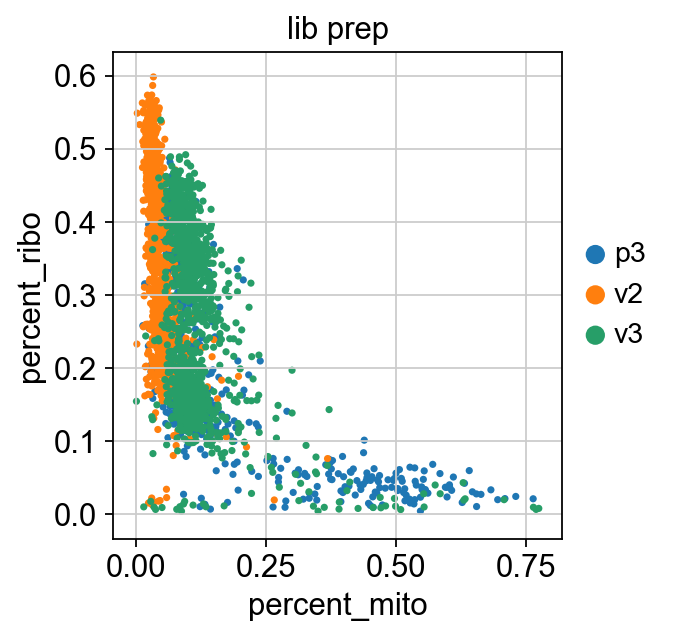

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='n_genes', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="lib_prep")
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="lib_prep")

In [13]:
adata

AnnData object with n_obs × n_vars = 2869 × 16780 
    obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'lib_prep_colors'

### Actually do the filtering.

Filter for: 

* percent_mito < 0.25
* gene detection 1000 -> 4100 (for v3)
* gene detection 500 -> 2000 (for v2)



In [14]:
# filter for percent mito
adata = adata[adata.obs['percent_mito'] < 0.25, :]

# filter for gene detection for v2
keep_v2 = (adata.obs['n_genes'] < 2000) & (adata.obs['n_genes'] > 500) & (adata.obs['lib_prep'] == 'v2')
print(sum(keep_v2))

# filter for gene detection for v3
keep_v3 = (adata.obs['n_genes'] < 4100) & (adata.obs['n_genes'] > 1000) & (adata.obs['lib_prep'] != 'v2')
print(sum(keep_v3))

# keep both sets of cells
keep = (keep_v2) | (keep_v3)
print(sum(keep))
adata = adata[keep, :]


933
1597
2530


In [15]:
adata

View of AnnData object with n_obs × n_vars = 2530 × 16780 
    obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'lib_prep_colors'

Plot the QC-stats again:

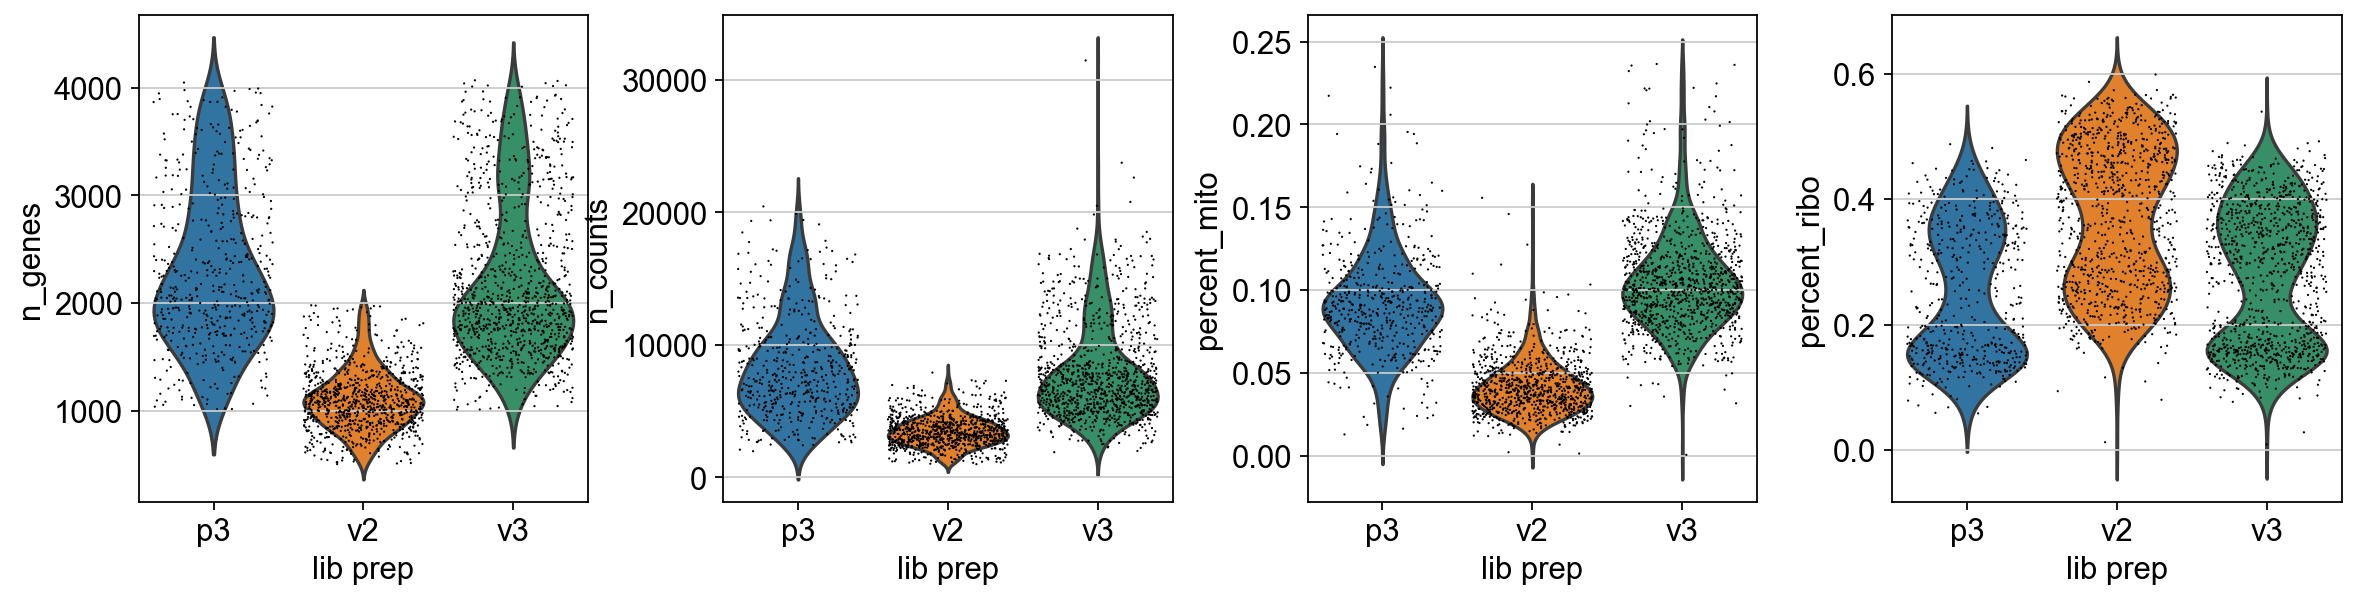

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

### Filter genes 

Remove all the mitochondrial genes and Malat1

In [17]:
malat1 = adata.var_names.str.startswith('MALAT1')
remove = np.add(mito_genes, malat1)
print(sum(remove))

keep = np.invert(remove)
print(sum(keep))

adata = adata[:,keep]


14
16766


In [18]:
adata

View of AnnData object with n_obs × n_vars = 2530 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'lib_prep_colors'

### Normalize the data

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

Save the raw data into a slot before running normalization and scaling

In [19]:
adata.raw = adata

In [20]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [21]:
sc.pp.log1p(adata)

Scale the data, for now, with no regression.

In [22]:
sc.pp.scale(adata)

### Cell cycle scoring

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. 

Cell cycle genes were retrieved from the scanpy_usage github site via web browser at:

https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [23]:
cell_cycle_genes = [x.strip() for x in open('./../data/misc/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
90


We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.


In [24]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01)
computing score 'G2M_score'
    finished (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


Plot distribution of cell cycle scores

... storing 'phase' as categorical


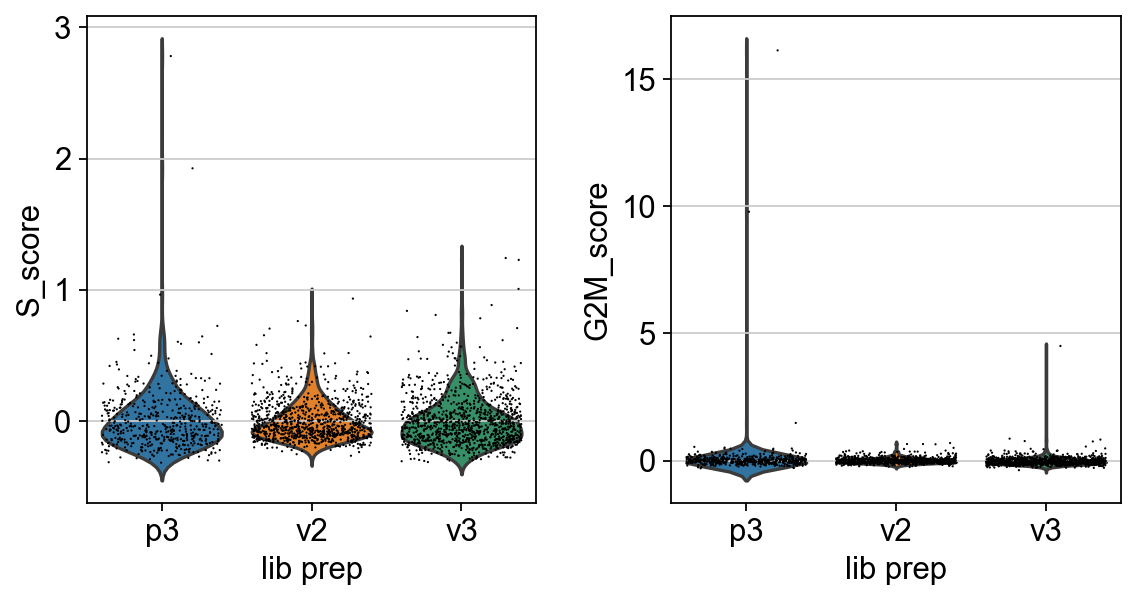

In [25]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'lib_prep')

## Save data for analysis

Save the QC-filtered dataset to a file


In [26]:
save_file = './../write/scanpy/qc_filtered_3pbmc.h5ad'
adata.write_h5ad(save_file)